In [8]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import wavfile
import collections

In [9]:
DATA_DIR = "/path/to/downloaded/WHAM/Vox/datasets"
WORKING_DIR = "/path/to/working/dir"

# WHAM noise files

We only take the files with SNR (calculate by the dataset creators) lower than a
certain threshold to remove the probability of there being audible speech in the noise.

In [10]:
# Load data and remove entries with SNR below threshold.
wham_test = pd.read_csv(os.path.join(DATA_DIR, "wham_noise", "metadata", "noise_meta_tt.csv"))
print(f"Number of WHAM test noise files: {len(wham_test):d}.")

Number of WHAM test noise files: 3000.


<AxesSubplot:ylabel='Density'>

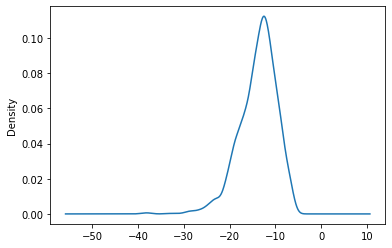

In [11]:
# Plot SNR values they provide.
wham_test["noise_snr"].plot(kind="kde")

In [12]:
# Remove files below SNR threshold. The SNR provided by WHAM is not always accurate.
# In other experiments, we observed that specifying an SNR cutoff of -12, leads to
# most files actually having an SNR below -6 dB.
threshold_snr_wham = -12

wham_test = wham_test[wham_test["noise_snr"] <= threshold_snr_wham]
print(f"Number of files with estimated SNR below threshold of {threshold_snr_wham:d}dB: {len(wham_test)}.")

wham_test.head()

Number of files with estimated SNR below threshold of -12dB: 1941.


,utterance_id,noise_file,start_sample_16k,end_sample_16k,noise_snr
0,445c0206_0.60431_22gc0105_-0.60431.wav,CalafiaTaqueria1facingeastat17_2018-11-16_11.4...,10259576,10374514,-19.342613
1,420c020h_1.1139_442c0203_-1.1139.wav,CalafiaTaqueria1facingeastat17_2018-11-16_11.4...,8860058,9035388,-17.904564
2,22go0107_0.079969_051c010u_-0.079969.wav,MakeWesting416minus30fromeast_2018-11-14_20.43...,7877497,8102501,-13.970667
3,444o0314_2.1819_053o020e_-2.1819.wav,WholeFoodsCafeTest1._2018-10-23_15.06.39_T001_...,18044582,18228848,-12.185235
4,423o0304_1.419_420c020x_-1.419.wav,CalafiaTaqueria1facingeastat17_2018-11-16_11.4...,10299938,10448472,-23.142106


In [13]:
# Calculation duration of all snippets.
duration = {}
for index, row in wham_test.iterrows():
    fs, audio_data = wavfile.read(os.path.join(DATA_DIR, "wham_noise", "tt", row["utterance_id"]))
    duration[index] = audio_data.shape[0] / fs

duration = pd.DataFrame.from_dict(duration, orient="index", columns=["duration"])
wham_test = wham_test.join(duration)

print("Min duration:", float(duration.min()))
print("Max duration:", float(duration.max()))
print("Average duration:", float(duration.mean()))
wham_test.head()

/Users/225pmeyerrac/python/datasets/venv/lib/python3.7/site-packages/audiotools/audio_segment.py:1173: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(file)


Min duration: 4.534625
Max duration: 22.37625
Average duration: 10.775349658681092


,utterance_id,noise_file,start_sample_16k,end_sample_16k,noise_snr,duration
0,445c0206_0.60431_22gc0105_-0.60431.wav,CalafiaTaqueria1facingeastat17_2018-11-16_11.4...,10259576,10374514,-19.342613,7.183625
1,420c020h_1.1139_442c0203_-1.1139.wav,CalafiaTaqueria1facingeastat17_2018-11-16_11.4...,8860058,9035388,-17.904564,10.958125
2,22go0107_0.079969_051c010u_-0.079969.wav,MakeWesting416minus30fromeast_2018-11-14_20.43...,7877497,8102501,-13.970667,14.062750
3,444o0314_2.1819_053o020e_-2.1819.wav,WholeFoodsCafeTest1._2018-10-23_15.06.39_T001_...,18044582,18228848,-12.185235,11.516625
4,423o0304_1.419_420c020x_-1.419.wav,CalafiaTaqueria1facingeastat17_2018-11-16_11.4...,10299938,10448472,-23.142106,9.283375


<AxesSubplot:ylabel='Density'>

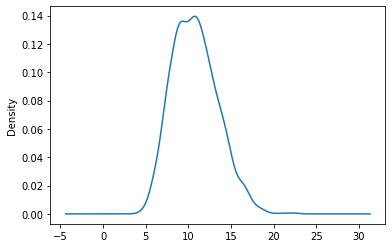

In [14]:
wham_test.duration.plot(kind="kde")

# Vox2 speech files

Use the test set from the vox2 dataset.

To make sure we do not accidentally train on samples in the test set, we compare
the database (it's actually more like a DataFrame but whatever) of our `dataset_v9`
files with the files in the test set we downloaded.

In [15]:
# Load database of files in `dataset_v9`.
database_speech = pd.read_csv(os.path.join(WORKING_DIR, "dataset_v9_speech_files.csv"))
vox2_ours = database_speech[(database_speech["dataset"] == "vox2")]
vox2_ours.head()

,dataset,name,accent,age,language,podcast,sex,speaker_id,subdataset,subset,type
0,vox2,id00012,NaN,NaN,NaN,NaN,m,id00012,NaN,train,speakers
1,vox2,id00015,NaN,NaN,NaN,NaN,m,id00015,NaN,test,speakers
2,vox2,id00016,NaN,NaN,NaN,NaN,m,id00016,NaN,train,speakers
3,vox2,id00018,NaN,NaN,NaN,NaN,m,id00018,NaN,train,speakers
4,vox2,id00019,NaN,NaN,NaN,NaN,m,id00019,NaN,train,speakers


In [16]:
# This csv contains all the files in the downloaded test set.
vox2 = pd.read_csv(os.path.join(WORKING_DIR, "estimated_snr_vox2.csv"), header=0)
vox2["speaker_id"] = vox2["file"].map(lambda x: x.split("/")[0])
print("Number of total test examples:", len(vox2))
vox2.head()

Number of total test examples: 36237


,file,snr_estimate,duration,speaker_id
0,id00017/01dfn2spqyE/00001.wav,13.377181,4.288027,id00017
1,id00017/5MkXgwdrmJw/00002.wav,11.646829,7.936009,id00017
2,id00017/7t6lfzvVaTM/00003.wav,21.811348,9.024036,id00017
3,id00017/7t6lfzvVaTM/00004.wav,18.984568,4.928027,id00017
4,id00017/7t6lfzvVaTM/00005.wav,17.977202,5.568027,id00017


In [17]:
# Now we check that there is no overlapping speaker IDs. The intersection should be
# empty.
assert set(vox2["speaker_id"]).intersection(set(vox2_ours["speaker_id"])) == set()

Analyse SNR and duration of Vox2 speech files.

(0.0, 10.0)

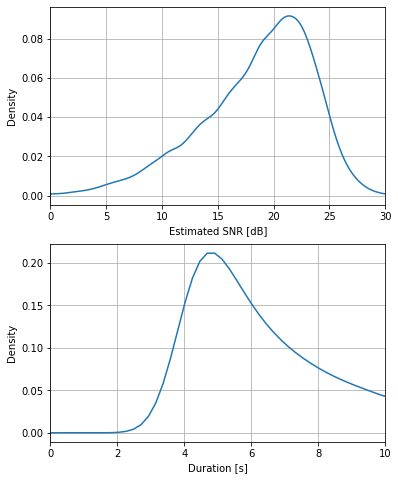

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
vox2["snr_estimate"].plot(kind="kde", ax=axes[0])
axes[0].grid()
axes[0].set_xlim(0, 30)
axes[0].set_xlabel("Estimated SNR [dB]")

vox2["duration"].plot(kind="kde", ax=axes[1])
axes[1].grid()
axes[1].set_xlabel("Duration [s]")
axes[1].set_xlim(0, 10)


Keep only files from the Vox2 data with high duration and SNR. There are so many that we can afford
to be picky.

In [19]:
threshold_snr_vox2 = 20
minimum_duration = 8

vox2 = vox2[(vox2["duration"] >= minimum_duration) & (vox2["snr_estimate"] >= threshold_snr_vox2)]
print("Number of samples meeting the requirements:", len(vox2))
print("Number of distinct speakers:", vox2["speaker_id"].nunique())

Number of samples meeting the requirements: 5737
Number of distinct speakers: 116


Plot number of examples per speaker.

Text(0.5, 0, 'Number of examples per speaker')

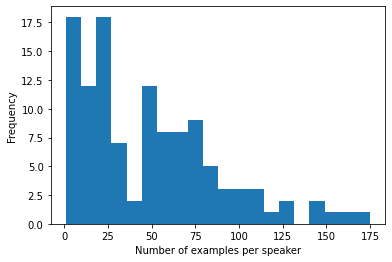

In [20]:
vox2_speakers = vox2.groupby("speaker_id").count()["file"]
fix, *axes = plt.subplots()
vox2_speakers.plot(kind="hist", ax=axes[0], bins=20)
axes[0].set_xlabel("Number of examples per speaker")

Load metadata of speakers. We use this to associate speaker ID with gender and make sure
that in the end we have a gender balanced dataset.

In [21]:
meta = pd.read_csv(os.path.join(WORKING_DIR, "vox2_meta.csv"))
meta = meta.applymap(lambda x: x.strip(" "))
meta.columns = meta.columns.map(lambda x: x.strip(" "))

meta = meta.set_index("VoxCeleb2 ID")
meta = meta[meta.index.isin(set(vox2_speakers.index))]
meta.head()

,VGGFace2 ID,Gender,Set
VoxCeleb2 ID,,,
id00017,n000017,m,test
id00061,n000061,m,test
id00081,n000081,m,test
id00154,n000154,m,test
id00419,n000419,f,test


In [22]:
# Check gender balance of total test set.
gender_balance = (meta.groupby("Gender").count() / len(meta)).iloc[:, 0]
gender_balance

Gender
f    0.327586
m    0.672414
Name: VGGFace2 ID, dtype: float64

# SNR distribution

Try to approximate the distribution from [1].

#### References:

    [1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5824438/figure/F4/

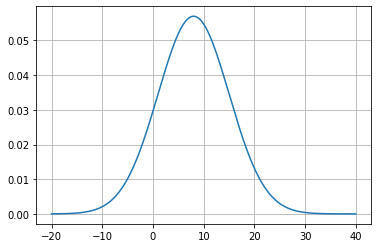

In [23]:
dist = stats.norm(loc=8, scale=7)

x = np.linspace(-20, 40, 1000)
y = dist.pdf(x)

fig, *axes = plt.subplots(nrows=1, ncols=1)
axes[0].plot(x, y)
axes[0].grid()

# Do the actual mixing

First, we need to select the files we want to mix. For WHAM, this is relatively easy,
we just take the files from the dataframe.

In [24]:
NUM_SAMPLES = 1941
SEED = 42

prefix_VoxCeleb = "aac"
prefix_WHAM = "tt"

files_WHAM = sorted(wham_test["utterance_id"].tolist())[:NUM_SAMPLES]
rand_WHAM = random.Random(SEED)
rand_WHAM.shuffle(files_WHAM)
print("Number of WHAM files:", len(files_WHAM))

Number of WHAM files: 1941


For Vox, this is a little harder since we want a balanced gender distribution and not
too many files from a single speaker.

In [25]:
# Get a separate list of all files for each gender.
vox2_files = vox2.groupby("speaker_id")["file"].apply(list)
vox2_files = vox2_files.to_frame().join(meta["Gender"])
vox2_files = vox2_files.groupby("Gender")["file"].apply(sum).to_frame()
vox2_files["num_files"] = vox2_files["file"].apply(len)
vox2_files

,file,num_files
Gender,,
f,"[id00419/1zffAxBod_c/00006.wav, id00419/3CulyF...",1625
m,"[id00017/7t6lfzvVaTM/00003.wav, id00017/Ktadqx...",4112


In [26]:
# Take all the female files (since there are fewer of them) and then take an equal
# amount of male files. Then shuffle. This does not guarantee a 50/50 split but almost.
files_VoxCeleb = []
files_VoxCeleb += vox2_files.loc["f", "file"]
files_VoxCeleb += vox2_files.loc["m", "file"][:len(files_VoxCeleb)]

rand_vox = random.Random(SEED + 7)
rand_vox.shuffle(files_VoxCeleb)
# We need to replace the extension from wav to m4a because when estimating the SNR, the
# file extension was wav (due to format conversion).
files_VoxCeleb = [file.replace(".wav", ".m4a") for file in files_VoxCeleb]
print("Number of VoxCeleb files:", len(files_VoxCeleb))

Number of VoxCeleb files: 3250


Sample SNR values. These will be the "default" SNR values, but can be adjusted by
the dataset generation script.

(array([  3.,   8.,   9.,  32.,  68., 110., 170., 243., 254., 287., 260.,
        181., 128.,  94.,  53.,  23.,  15.,   1.,   1.,   1.]),
 array([-14.68887138, -12.20597179,  -9.7230722 ,  -7.24017261,
         -4.75727302,  -2.27437343,   0.20852616,   2.69142575,
          5.17432535,   7.65722494,  10.14012453,  12.62302412,
         15.10592371,  17.5888233 ,  20.07172289,  22.55462248,
         25.03752207,  27.52042166,  30.00332125,  32.48622084,
         34.96912043]),
 <BarContainer object of 20 artists>)

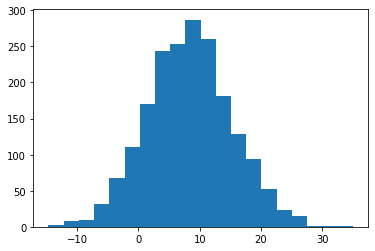

In [27]:
snr_values = dist.rvs(random_state=SEED, size=(NUM_SAMPLES,))
plt.hist(snr_values, bins=20)

Save file combination to CSV together with gender and suggested SNR.

In [28]:
MixedFile = collections.namedtuple(
    "MixedFile", ("file_noise", "file_speech", "SNR", "gender", "speaker_id")
)

files = []
for i in range(NUM_SAMPLES):

    file_speech = os.path.join(prefix_VoxCeleb, files_VoxCeleb[i])
    file_noise = os.path.join(prefix_WHAM, files_WHAM[i])
    snr = snr_values[i]
    speaker_id = files_VoxCeleb[i].split("/")[0]
    gender = meta.loc[speaker_id, "Gender"]
    files.append(
        MixedFile(
            file_noise=file_noise,
            file_speech=file_speech,
            SNR=snr,
            gender=gender,
            speaker_id=speaker_id
        )
    )

files = pd.DataFrame(files)
files.to_csv(os.path.join(WORKING_DIR, "WHAMVox_test.csv"), index=False)
files.head()

,file_noise,file_speech,SNR,gender,speaker_id
0,tt/445c020w_0.87572_22ga010s_-0.87572.wav,aac/id00017/gjYcaCzo7UU/00107.m4a,11.476999,m,id00017
1,tt/22ga010x_0.48458_22ho0107_-0.48458.wav,aac/id02019/X3FCAoFnmdA/00130.m4a,7.032150,m,id02019
2,tt/051a050o_1.2715_443o030c_-1.2715.wav,aac/id02086/1cJl_a8WpuY/00022.m4a,12.533820,f,id02086
3,tt/22ha0114_0.35843_441o030e_-0.35843.wav,aac/id02057/CI5-q_qTR5I/00112.m4a,18.661209,m,id02057
4,tt/442c020n_1.8408_444o030k_-1.8408.wav,aac/id01593/NuGK5k5cpoA/00279.m4a,6.360926,m,id01593


Verify that gender balance is okay.

In [33]:

files.groupby(["gender"]).nunique()

,file_noise,file_speech,SNR,gender,speaker_id
gender,,,,,
f,968,968,968,1,37
m,973,973,973,1,32
